# Power spectra of mock cluster observations

## Last edited by Charles Romero 08 June 2025

Now that we've considered power spectra in an image which is described by some power spectrum, let's consider the actual kind of image (but idealized, of course) that we might encounter.

In [5]:
import MockMaps as MM
import matplotlib.pyplot as plt
import numpy as np
import CalculatePS as CPS
import SelfSimilar_GalaxyClusters as SSGC
import PowerSpectraWindows as PSW
import astropy.units as u

In [46]:
from importlib import reload

### Pick a cluster

Defined by self-similar criteria, i.e. solely z and $M_{500}$.

In [6]:
z = 0.4
M500 = 5e14 * u.M_sun 

In [7]:
d_ang = SSGC.get_d_ang(z).to("kpc").value
kpc_per_arcsecond = d_ang / (3600 * 180 / np.pi)
print("kpc per arcsecond: ",kpc_per_arcsecond)

kpc per arcsecond:  5.37273628890832


In [8]:
Outputs = SSGC.get_XR_USBP(z,M500,npts=500,SoftOnly=True)
radians = Outputs[0] # Array of radii, in radians
SBProf = Outputs[1] # Array of X-ray surface brightness (cnts/s/arcmin**2) for XMM like observations
t500 = Outputs[2] # Theta_500 in arcminutes

## Grid this profile onto a map

Let's make a map with a given power spectrum. In particular, let's choose a plausible (idealized, as always) power spectrum for density fluctuations.

In [44]:
# Same as the previous notebook.
kc = 3e-3        # Assume this is in [pixsize]^(-1) -- so kpc^-1 in our case.
slope = -3       # Power goes as k**slope
p0 = 3e-2         # Arbitrary units at the moment
ks = np.logspace(-4,0.5,500)
ps = MM.get_P3d(ks,slope=slope,kc=kc,p0=p0) # More optional inputs: kdis=kdis,eta_c=eta_c,eta_d=eta_d
a3d = np.sqrt(4*np.pi*ks**3 * ps)
print(np.max(a3d))
#ymin = MM.get_P3d(np.array([kc/2.0]),slope=slope,kc=kc,p0=p0)

0.10634714083317866


In [45]:
pix_arcsec = 2.5 # Typical pixel size for XMM images (EPIC cameras), in arcseconds
pixsize = pix_arcsec*kpc_per_arcsecond    # in kpc
# XMM's EPIC cameras have a ~30' FOV. So they go out to 15' radially.
# We could try to replicate that in earnest.
# Or we could trim the image down to 2*R500, radially
nx = int(np.round(t500*4*60/pix_arcsec))        # Number of pixels in x-direction
ny = nx                          # Same number as in x -- keep things simple.

In [61]:
image = MM.make_image(ks,ps,nx=nx,ny=ny,cx=nx//2,cy=ny//2,pixsize=pixsize)
xsize = pix_arcsec*nx/60.0
ysize = xsize
xymap = MM.make_xymap(xsize,ysize,pix_arcsec,cx=None,cy=None)
rad_arcsec = radians*3600*180/np.pi
BetaMap = MM.grid_profile(radians, SBProf, xymap)

What to do.

In [63]:
Wradians,WNs = PSW.get_window_XR_kpc(M500,z) # Wradians should be the same as the variable "radians" above.
# Since Wradians matches radians, rad_arcsec will also corresponds to WNs
N_Map = MM.grid_profile(rad_arcsec, WNs, xymap) # Map of N values (in kpc)

In [64]:
dS_S = N_Map * image     # Normalized residual.
dS = dS_S * BetaMap      # Residual image in cnts/s/arcmin**2
S_cluster = dS + BetaMap # Image in cnts/s/arcmin**2

In [65]:
print(np.min(N_Map),np.min(image),np.min(dS),np.min(S_cluster))

0.00853909316984688 -6.505269770615641 -0.017681732735615283 4.935063031090521e-05


In [66]:
print(np.min(BetaMap),np.max(BetaMap))

4.870179796982996e-05 1.1012494251719045


In [87]:
MM = reload(MM)
PSW=reload(PSW)

In [88]:
ksec = 50 # kiloseconds
exposure_map = MM.mock_XMM_exposure(xymap,ksec,rot=30,incChipGaps=True) # in seconds

In [89]:
S_particle_bkg = 1e-3                  # This is a typical uniform, quiescent particle X-ray background. Soft protons and SWCX usually are sub-dominant.
S_cosmic_bkg = 1e-3                    # The cosmic X-ray background
S_bkg = S_particle_bkg + S_cosmic_bkg  # Total background rate

In [90]:
S_tot = S_cluster + S_bkg # Assume that we can account for all photons in this manner
### A very notable contribution (not accounted for here) are point sources
Counts_Total = S_tot * exposure_map * (pix_arcsec/60)**2

In [91]:
rng = np.random.default_rng()
SyntheticImage = rng.poisson(lam=Counts_Total)

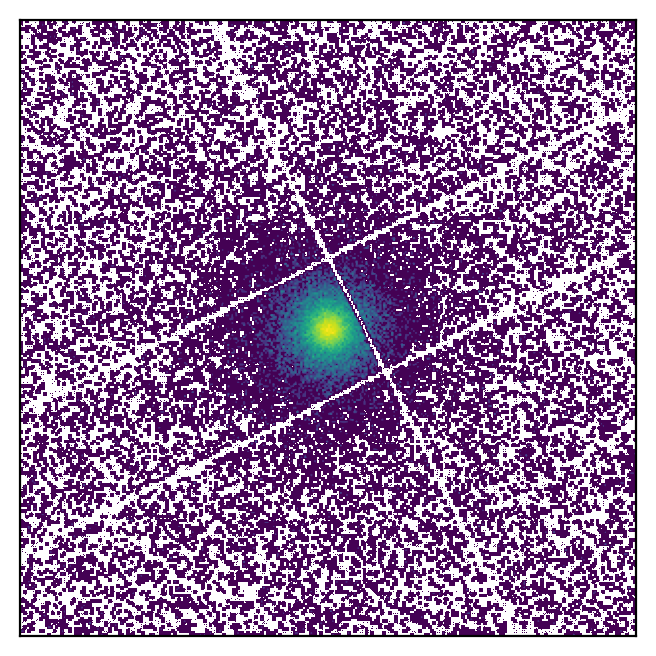

In [92]:
CntFig = plt.figure(1,figsize=(4,4),dpi=200)
CntAx = CntFig.add_subplot(111)
CntAx.imshow(SyntheticImage,norm="log")
#xlims = CntAx.get_xlim()
#ylims = CntAx.get_ylim()
#CntAx.set_xlim(xlims)
#CntAx.set_ylim(ylims)
    
CntAx.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)

## Exercise for the reader

Now that you've seen the construction of this image and how to calculate the power spectrum, you should try to compute the power spectrum of the fluctuations from only `SyntheticImage` and `exposure_map`. In principle, ESAS (the XMM processing software) will also produce a background map due to particles. So, rather than a uniform map (taken as a scalar above), `S_particle_bkg` would be a map produced by ESAS (but in counts, with non-negative float values).

### General steps:
1. Fit a surface brightness profile to the data
2. Calculate a $\delta S / S$ map
3. Calculate "the" power spectrum 
   * Within what region(s)?
5. Deproject from the image PS ($P_{2D}$) to the 3-d power spectrum ($P_{3D}$)